# MultiClass Classification with CNN

Build a CNN model to classify a single object in an image (the image contains only 01 object).

Dataset for training: https://www.kaggle.com/prasunroy/natural-images

08 classes: {"airplane":0,  "car":1,  "cat":2,  "dog":3,  "flower":4,  "fruit":5,  "motorbike":6,  "person":7}

Multiclass classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

Multilabel classification assigns to each sample a set of target labels.



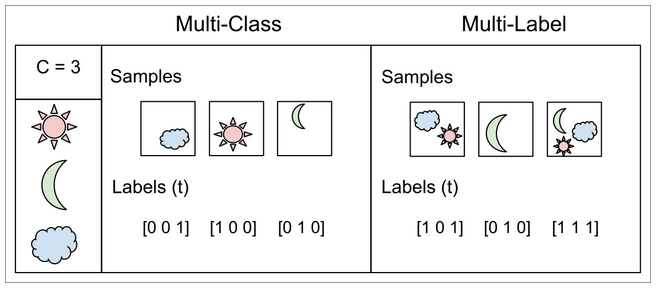

# Connect to Kaggle

Ref: https://galhever.medium.com/how-to-import-data-from-kaggle-to-google-colab-8160caa11e2

Install the Kaggle package that will be used for importing the data.

In [ ]:
!pip install kaggle

Next, we need to upload the credentials of our Kaggle account. To do so, you need to enter your profile and “Create New API Token”. If you already have one you can click on “Expire API Token” and create a new one.

Then, save the json file with your credentials on your computer and upload this file to Colab using the code below:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kiemhiep","key":"346d05746c99fb614062800d8014518f"}'}

The Kaggle API client expects the json file to be in ~/.kaggle folder so let’s create a new folder and move it inside.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset (Natural Images)

Natural Image Dataset from Kaggle: https://www.kaggle.com/prasunroy/natural-images

Next, we will click on the three vertical points on the right side of the screen and “Copy the API Command” of the dataset that we want to import from Kaggle.

In [ ]:
# !kaggle datasets download -d jessicali9530/celeba-dataset
# https://github.com/prasunroy/cnn-on-degraded-images
# https://github.com/prasunroy/cnn-on-degraded-images
! kaggle datasets download -d prasunroy/natural-images

 96% 330M/342M [00:03<00:00, 124MB/s]
100% 342M/342M [00:03<00:00, 108MB/s]


In [ ]:
!pwd

/content


In [ ]:
!ls

kaggle.json  natural-images.zip  sample_data


Now, the last step is to open the extracted files and get the data:

In [ ]:
# Extract to directory /files
import zipfile
zip_ref = zipfile.ZipFile('natural-images.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
!ls

files  kaggle.json  natural-images.zip	sample_data


In [ ]:
! rm -rf celeba-dataset.zip

In [ ]:
!ls

files  kaggle.json  natural-images.zip	sample_data


In [ ]:
% cd files

/content/files


In [ ]:
!ls

data  natural_images


# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import shutil
import glob

import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input

from tqdm import tqdm

from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# import PIL.Image as Image, PIL.ImageDraw as Draw, PIL.ImageFont as Font

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from tensorflow.keras.models import load_model 
from tensorflow.keras.preprocessing import image

import scipy
from scipy.ndimage import rotate


import time, gc

# Data Directory

In [ ]:
DATA_PATH = '/content/files/'
DATA_DIR  = os.path.join(DATA_PATH, 'natural_images')
DATA_DIR

'/content/files/natural_images'

In [ ]:
os.listdir(DATA_DIR)

['flower', 'dog', 'car', 'airplane', 'fruit', 'person', 'cat', 'motorbike']

In [ ]:
items = glob.glob(os.path.join(DATA_DIR, '*'))
items

['/content/files/natural_images/flower',
 '/content/files/natural_images/dog',
 '/content/files/natural_images/car',
 '/content/files/natural_images/airplane',
 '/content/files/natural_images/fruit',
 '/content/files/natural_images/person',
 '/content/files/natural_images/cat',
 '/content/files/natural_images/motorbike']

# Read data

Read all classes from the dataset

In [ ]:
classes = os.listdir(DATA_DIR)
print('Number of classes: ', len(classes))
print(classes)

Number of classes:  8
['flower', 'dog', 'car', 'airplane', 'fruit', 'person', 'cat', 'motorbike']


In [ ]:
LABELS = {"airplane":0,  "car":1,  "cat":2,  "dog":3,  "flower":4,  "fruit":5,  "motorbike":6,  "person":7}
LABELS_R = {}
for itm in LABELS.keys():
  LABELS_R[LABELS[itm]] = itm

LABELS_R

{0: 'airplane',
 1: 'car',
 2: 'cat',
 3: 'dog',
 4: 'flower',
 5: 'fruit',
 6: 'motorbike',
 7: 'person'}

In [ ]:
all_file_paths = glob.glob( os.path.join(DATA_DIR, '*', '*.jpg') )
len(all_file_paths)

6899

In [ ]:
all_file_labels = [ x.split('/')[-2] for x in all_file_paths ]
len(all_file_labels)

6899

In [ ]:
all_file_labels[:2]

['flower', 'flower']

In [ ]:
all_label_ids = [ LABELS[x] for x in all_file_labels]
len(all_label_ids)

6899

In [ ]:
LABELS

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [ ]:
# Create dataframe, Shuffle the DataFrame and reset index
df = pd.DataFrame({'path': all_file_paths, 'labels': all_file_labels, 'label_ids': all_label_ids})
df = df.sample(frac=1, random_state=0).reset_index(drop = True) 
df.head()

,path,labels,label_ids
0,/content/files/natural_images/motorbike/motorb...,motorbike,6
1,/content/files/natural_images/airplane/airplan...,airplane,0
2,/content/files/natural_images/car/car_0664.jpg,car,1
3,/content/files/natural_images/person/person_00...,person,7
4,/content/files/natural_images/airplane/airplan...,airplane,0


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.labels.unique())}\n')
print(f'Labels: {df.labels.unique()}')

Number of pictures: 6899

Number of different labels: 8

Labels: ['motorbike' 'airplane' 'car' 'person' 'cat' 'flower' 'dog' 'fruit']


In [ ]:
label_counts = df['label_ids'].value_counts().sort_values(ascending=True)
label_counts

3     702
0     727
6     788
4     843
2     885
1     968
7     986
5    1000
Name: label_ids, dtype: int64

In [ ]:
[LABELS_R[x] for x in label_counts.index.tolist()]

['dog', 'airplane', 'motorbike', 'flower', 'cat', 'car', 'person', 'fruit']

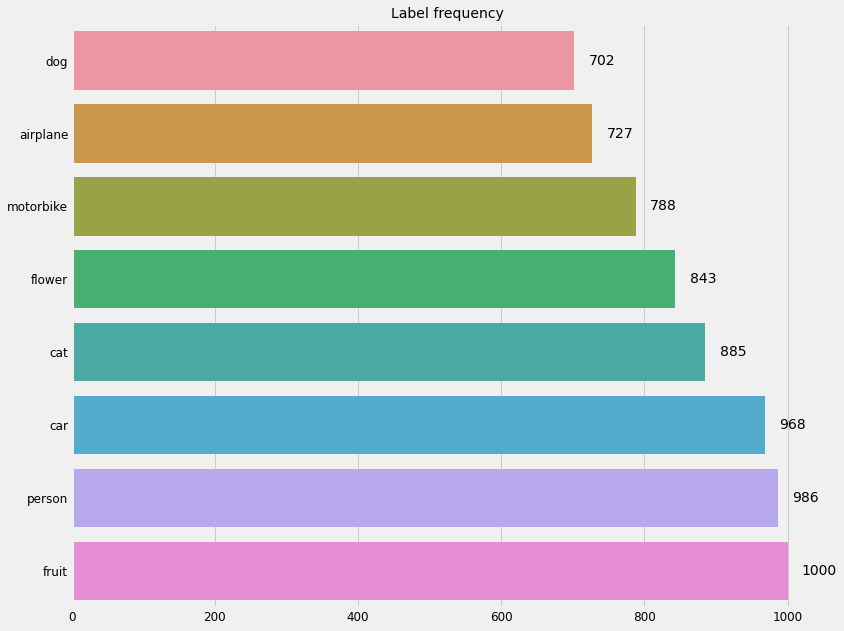

In [ ]:
# Bar plot
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,10))


ax = sns.barplot(y=[LABELS_R[x] for x in label_counts.index.tolist()], x=label_counts.values, order=[LABELS_R[x] for x in label_counts.index.tolist()])

for p in ax.patches:
  width = p.get_width()    # get bar length
  ax.text(width + 20,       # set the text at 20 unit right of the bar
    p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
    '{:1.0f}'.format(width), # set variable to display, 2 decimals
    ha = 'left',   # horizontal alignment
    va = 'center')  # vertical alignment


plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# # Plot barchart
# colors = ["purple", "green", "orange","blue", "red", "pink", "skyblue", "black"]

# sns.set_style("whitegrid")

# plt.figure(figsize=(12,6))
# # plt.title("-", fontsize = 25)
# plt.xlabel("Labels")
# plt.ylabel("Number of images")
# sns.barplot(x = label_counts.index, y = label_counts.values, palette=colors )
# plt.show()

# Imbalanced Classes

This dataset is not very imbalanced. However, I'll add class-weights to deal with this as it's imbalanced.

In [ ]:
label_freq_df = label_counts.to_frame(name='freq').reset_index()
label_freq_df.rename(columns={'index': 'labels'}, inplace=True)
label_freq_df

,labels,freq
0,3,702
1,0,727
2,6,788
3,4,843
4,2,885
5,1,968
6,7,986
7,5,1000


In [ ]:
print(label_freq_df['freq'].sum())
print(label_freq_df.index)
# print(label_freq_df.values)
print(label_freq_df.loc[1])

6899
RangeIndex(start=0, stop=8, step=1)
labels      0
freq      727
Name: 1, dtype: int64


Some labels occur more often than others, thus the classes are not well balanced. The imbalanced class problem can be addressed by applying class weights, thus weighting less frequent labels higher than very frequent labels.

In [ ]:
label_freq_df['class_weight'] = label_freq_df['freq'].sum() / label_freq_df['freq']
label_freq_df

,labels,freq,class_weight
0,3,702,9.827635
1,0,727,9.489684
2,6,788,8.755076
3,4,843,8.183867
4,2,885,7.795480
5,1,968,7.127066
6,7,986,6.996957
7,5,1000,6.899000


In [ ]:
class_weight = {}
for index, label in enumerate(label_freq_df['labels']):
    class_weight[label] = label_freq_df.loc[index]['class_weight']

class_weight

{0: 9.48968363136176,
 1: 7.12706611570248,
 2: 7.7954802259887,
 3: 9.827635327635328,
 4: 8.183867141162516,
 5: 6.899,
 6: 8.75507614213198,
 7: 6.996957403651115}

# Show some images

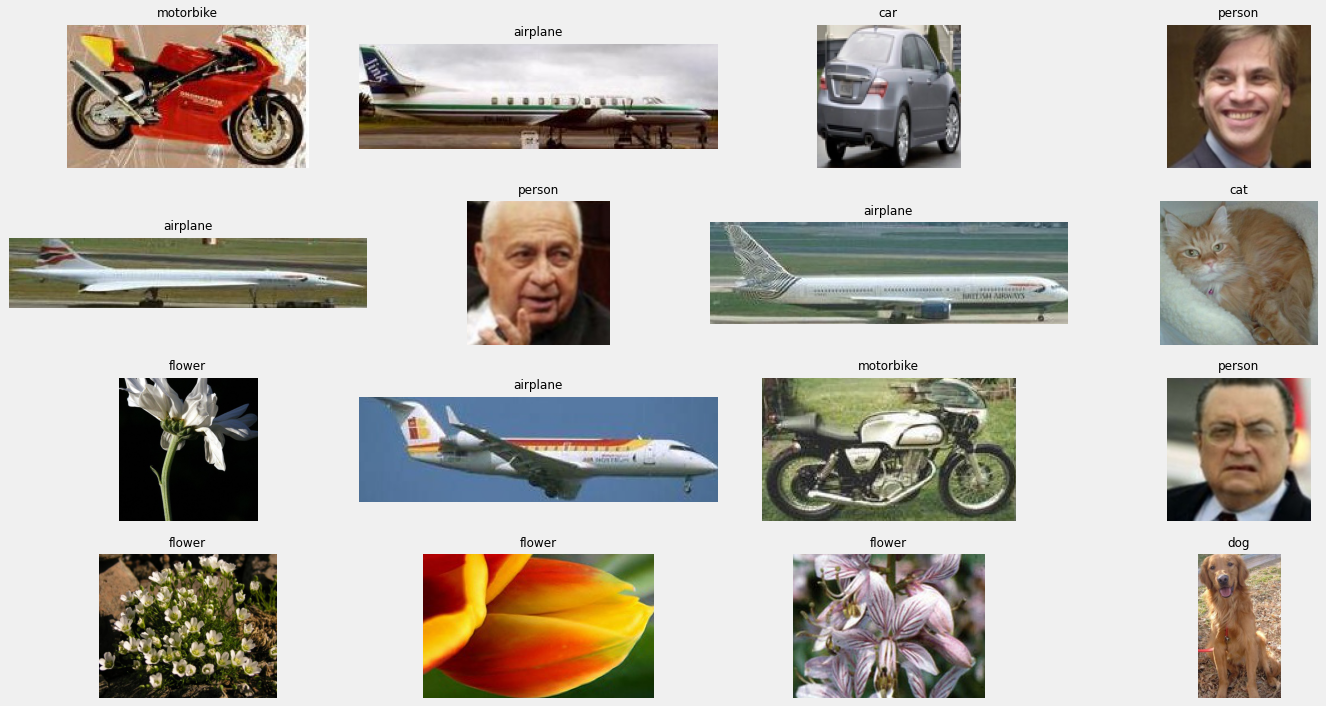

In [ ]:
fig, axe = plt.subplots(nrows=4,
                        ncols=4,
                        figsize=(20, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axe.flat):
  ax.imshow(plt.imread(df['path'][i]))
  ax.set_title(df['labels'][i], fontsize = 12)

plt.tight_layout(pad=1)
plt.show()

# Training and test datasets

In [ ]:
label_series = df['labels']
label_series

0       motorbike
1        airplane
2             car
3          person
4        airplane
          ...    
6894       person
6895        fruit
6896          car
6897     airplane
6898     airplane
Name: labels, Length: 6899, dtype: object

In [ ]:
df = df.drop(['labels'], axis=1)
df.head()

,path,label_ids
0,/content/files/natural_images/motorbike/motorb...,6
1,/content/files/natural_images/airplane/airplan...,0
2,/content/files/natural_images/car/car_0664.jpg,1
3,/content/files/natural_images/person/person_00...,7
4,/content/files/natural_images/airplane/airplan...,0


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
print("Training set shape: ", train_df.shape)
print("Test set shape: ", test_df.shape)

Training set shape:  (6209, 2)
Test set shape:  (690, 2)


In [ ]:
train_df.head()

,path,label_ids
4762,/content/files/natural_images/flower/flower_06...,4
5783,/content/files/natural_images/flower/flower_05...,4
5719,/content/files/natural_images/fruit/fruit_0609...,5
1934,/content/files/natural_images/car/car_0649.jpg,1
3856,/content/files/natural_images/flower/flower_00...,4


# Data Augmentation

In [ ]:
def generate():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split=0.15)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label_ids',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        rotation_range = 30,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label_ids',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        subset='validation'
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='label_ids',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator, test_generator, train_images, val_images, test_images

In [ ]:
train_generator, test_generator, train_images, val_images, test_images = generate() 

Found 5278 validated image filenames.
Found 931 validated image filenames.
Found 690 validated image filenames.


In [ ]:
# Training set: file paths
print(train_images._filepaths[:3])
len(train_images._filepaths)

['/content/files/natural_images/flower/flower_0671.jpg', '/content/files/natural_images/cat/cat_0170.jpg', '/content/files/natural_images/motorbike/motorbike_0091.jpg']


5278

In [ ]:
# Training set: labels
print(train_images._targets[:3])
len(train_images._targets)

[4 2 6]


5278

# CNN model

In [ ]:
SIZE = 224
N_LABELS = len(classes)


# Build CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(SIZE,SIZE,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Conv2D(128, (5,5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(N_LABELS, activation='softmax'))

# Softmax is useful for mutually exclusive classes, either cat or dog but not both.
# Also, softmax outputs all add to 1. So good for multi class problems where each
# class is given a probability and all add to 1. Highest one wins.
# (Do not use softmax for multilabel classification).

# Sigmoid outputs probability. Can be used for non-mutually exclusive problems.
# like multi label, in this example.
# But, also good for binary mutually exclusive (cat or not cat). 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 106, 106, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0

In [ ]:
model.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

# Train the model

In [ ]:
callbacks_list = [
                 tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5)
                ] 

history = model.fit(train_images,
                    validation_data=val_images,
                    class_weight=class_weight,
                    epochs=40,
                    validation_steps = len(val_images),
                    callbacks = callbacks_list)  

Epoch 1/40
165/165 [==============================] - 55s 124ms/step - loss: 11.7301 - accuracy: 0.5328 - val_loss: 2.9075 - val_accuracy: 0.1751
Epoch 2/40
165/165 [==============================] - 19s 118ms/step - loss: 6.3199 - accuracy: 0.7393 - val_loss: 2.0707 - val_accuracy: 0.4479
Epoch 3/40
165/165 [==============================] - 19s 115ms/step - loss: 4.8510 - accuracy: 0.7906 - val_loss: 0.7737 - val_accuracy: 0.7218
Epoch 4/40
165/165 [==============================] - 19s 115ms/step - loss: 3.6438 - accuracy: 0.8352 - val_loss: 0.5287 - val_accuracy: 0.8077
Epoch 5/40
165/165 [==============================] - 19s 115ms/step - loss: 3.0387 - accuracy: 0.8613 - val_loss: 0.4510 - val_accuracy: 0.8153
Epoch 6/40
165/165 [==============================] - 19s 114ms/step - loss: 2.9983 - accuracy: 0.8691 - val_loss: 0.4504 - val_accuracy: 0.8292
Epoch 7/40
165/165 [==============================] - 19s 115ms/step - loss: 2.5768 - accuracy: 0.8865 - val_loss: 0.4229 - val_a

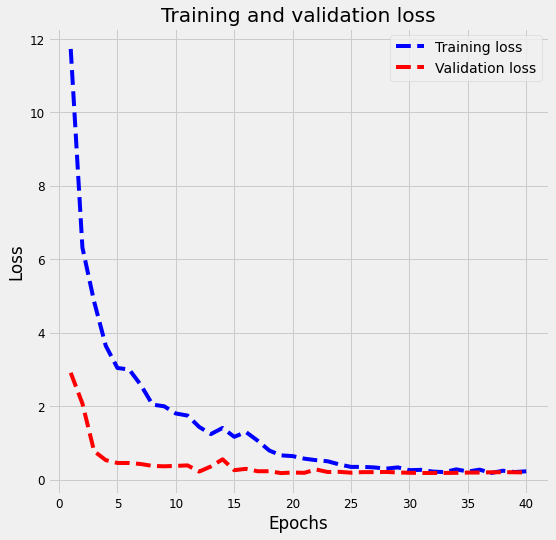

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)



plt.figure(figsize=(8,8))

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

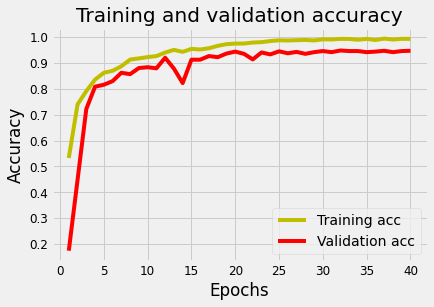

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model

In [ ]:
model_eval = model.evaluate(test_images)
print('Model evaluation: ')
model_eval

22/22 [==============================] - 2s 102ms/step - loss: 0.1998 - accuracy: 0.9551
Model evaluation: 


[0.19983692467212677, 0.9550724625587463]

In [ ]:
print("Total loss: ", model_eval[0])
print("Total accuracy: ", model_eval[1])


Total loss:  0.19983692467212677
Total accuracy:  0.9550724625587463


Check from the prediction:

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1)

In [ ]:
len(pred)

690

In [ ]:
pred[:10]

array([2, 6, 1, 4, 3, 2, 0, 2, 7, 1])

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display


# Map the label
LABELS_R

{0: 'airplane',
 1: 'car',
 2: 'cat',
 3: 'dog',
 4: 'flower',
 5: 'fruit',
 6: 'motorbike',
 7: 'person'}

In [ ]:
pred_lables = [LABELS_R[k] for k in pred]
pred_lables[:10]

['cat',
 'motorbike',
 'car',
 'flower',
 'dog',
 'cat',
 'airplane',
 'cat',
 'person',
 'car']

In [ ]:
len(test_df.label_ids)

690

In [ ]:
y_test = test_df.label_ids
acc = accuracy_score(y_test, pred)
total_acc = round(acc,4)
print("Total accuracy: ", total_acc)

Total accuracy:  0.9551


In [ ]:
label_ids = [x for x in range(N_LABELS)]
label_ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
# evaluate the network
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        75
           1       1.00      0.99      1.00       109
           2       0.81      0.94      0.87        87
           3       0.81      0.80      0.81        60
           4       1.00      0.90      0.95        90
           5       1.00      1.00      1.00       103
           6       1.00      0.97      0.99        78
           7       1.00      0.99      0.99        88

    accuracy                           0.96       690
   macro avg       0.95      0.95      0.95       690
weighted avg       0.96      0.96      0.96       690



# Prediction with new images

In [ ]:
class_names = np.array( [LABELS_R[x] for x in range(N_LABELS)] )
class_names

array(['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike',
       'person'], dtype='<U9')

## Case 1

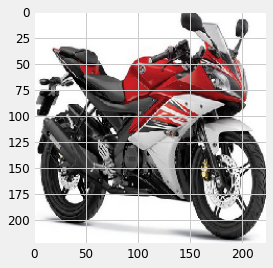

In [ ]:
img = image.load_img(DATA_PATH + '/mtbk1.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [ ]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [ ]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[1.9536295e-05, 4.0365048e-06, 2.2389097e-05, 3.9405506e-05,
        3.8094871e-04, 5.2884370e-06, 9.9952555e-01, 2.9156599e-06]],
      dtype=float32)

In [ ]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['motorbike', 'flower', 'dog', 'cat', 'airplane'], dtype='<U9')

## Case 2

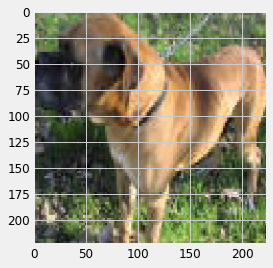

In [ ]:
img = image.load_img(DATA_PATH + '/dog01.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [ ]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [ ]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[6.4987802e-08, 4.9310273e-07, 9.4292824e-05, 9.9989164e-01,
        6.0204238e-06, 2.0018992e-07, 3.2207031e-06, 3.9705915e-06]],
      dtype=float32)

In [ ]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['dog', 'cat', 'flower', 'person', 'motorbike'], dtype='<U9')

## Case 3

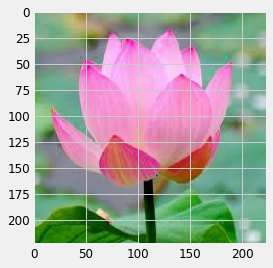

In [ ]:
img = image.load_img(DATA_PATH + '/flower1.jpeg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [ ]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [ ]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[1.44406329e-06, 7.38173594e-06, 6.95885228e-06, 1.43778825e-05,
        9.99965549e-01, 8.05428044e-07, 1.10750159e-06, 2.29202351e-06]],
      dtype=float32)

In [ ]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['flower', 'dog', 'car', 'cat', 'person'], dtype='<U9')

## Case 4

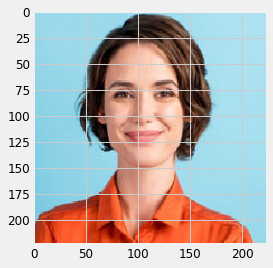

In [ ]:
img = image.load_img(DATA_PATH + '/person.jpg',target_size=(SIZE, SIZE, 3))
img = image.img_to_array(img)
img = img/255

plt.imshow(img)
plt.show()

Now, we will predict the genre for these posters using our trained model. The model will tell us the probability for each genre and we will take the top 3 predictions from that.

In [ ]:
# Reshape the image into Batch style [batch, Size, Size, channel]
img = img.reshape(1,SIZE,SIZE,3)

In [ ]:
# Probability of each label
predicted_prob = model.predict(img)
predicted_prob

array([[1.4578253e-04, 3.1982971e-05, 2.0919868e-03, 1.3839524e-03,
        1.1649885e-03, 9.1786012e-03, 5.5331300e-04, 9.8544937e-01]],
      dtype=float32)

In [ ]:
# Sort the predicted_probability (decending order) and take the indexes
indexes = np.argsort(predicted_prob[0])[::-1]
predicted_prob[0][indexes]

# All labels with decending order of probability
class_names[indexes]

# Top 5
class_names[indexes][:5]

array(['person', 'fruit', 'cat', 'dog', 'flower'], dtype='<U9')

# Save the model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("MCC_model_classweight.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("MCC_model_classweight_weight.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# save the network to disk
print("Save the model...")
model.save("MultiClass_Classification_CNN_model_classweight.model", save_format="h5")

Save the model...


In [ ]:
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))